Copyright (c) Microsoft Corporation. All rights reserved. 

Licensed under the MIT License.

# AutoML with FLAML Library


## 1. Introduction

FLAML is a Python library (https://github.com/microsoft/FLAML) designed to automatically produce accurate machine learning models 
with low computational cost. It is fast and economical. The simple and lightweight design makes it easy to use and extend, such as adding new learners. FLAML can 
- serve as an economical AutoML engine,
- be used as a fast hyperparameter tuning tool, or 
- be embedded in self-tuning software that requires low latency & resource in repetitive
   tuning tasks.

In this notebook, we use one real data example (binary classification) to showcase how to use FLAML library.

FLAML requires `Python>=3.7`. To run this notebook example, please install flaml with the `notebook` option:
```bash
pip install flaml[notebook]
```

In [ ]:
%pip install flaml[notebook]
# from v0.6.6, catboost is made an optional dependency to build conda package.
# to install catboost without installing the notebook option, you can run:
# %pip install flaml[catboost]

## 2. Classification Example
### Load data and preprocess

Download [Airlines dataset](https://www.openml.org/d/1169) from OpenML. The task is to predict whether a given flight will be delayed, given the information of the scheduled departure.

In [1]:
from flaml.data import load_openml_dataset
X_train, X_test, y_train, y_test = load_openml_dataset(dataset_id=1169, data_dir='./')
print("Data type:", type(X_train), type(y_train))
print("The first 5 rows of X_train:")
print(X_train.head())
print("The first 5 rows of y_train:")
print(y_train.head())

load dataset from ./openml_ds1169.pkl
Dataset name: airlines
X_train.shape: (404537, 7), y_train.shape: (404537,);
X_test.shape: (134846, 7), y_test.shape: (134846,)
Data type: <class 'pandas.core.frame.DataFrame'> <class 'pandas.core.series.Series'>
The first 5 rows of X_train:
       Airline  Flight AirportFrom AirportTo DayOfWeek   Time  Length
249392      EV  5309.0         MDT       ATL         3  794.0   131.0
166918      CO  1079.0         IAH       SAT         5  900.0    60.0
89110       US  1636.0         CLE       CLT         1  530.0   103.0
70258       WN   928.0         CMH       LAS         7  480.0   280.0
492985      WN   729.0         GEG       LAS         3  630.0   140.0
The first 5 rows of y_train:
249392    1
166918    0
89110     0
70258     0
492985    1
Name: Delay, dtype: category
Categories (2, object): ['0' < '1']


### Run FLAML
In the FLAML automl run configuration, users can specify the task type, time budget, error metric, learner list, whether to subsample, resampling strategy type, and so on. All these arguments have default values which will be used if users do not provide them. For example, the default classifiers are `['lgbm', 'xgboost', 'xgb_limitdepth', 'catboost', 'rf', 'extra_tree', 'lrl1']`. 

In [29]:
''' import AutoML class from flaml package '''
from flaml import AutoML
automl = AutoML()

In [30]:
settings = {
    "time_budget": 600,  # total running time in seconds
    "metric": 'accuracy',  # can be: 'r2', 'rmse', 'mae', 'mse', 'accuracy', 'roc_auc', 'roc_auc_ovr',
                           # 'roc_auc_ovo', 'log_loss', 'mape', 'f1', 'ap', 'ndcg', 'micro_f1', 'macro_f1'
    "task": 'classification',  # task type
    "log_file_name": 'airlines_experiment.log',  # flaml log file
    "seed": 7654321,    # random seed
}

In [31]:
'''The main flaml automl API'''
automl.fit(X_train=X_train, y_train=y_train, **settings)

[flaml.automl: 08-19 14:08:37] {2447} INFO - task = classification
[flaml.automl: 08-19 14:08:37] {2449} INFO - Data split method: stratified
[flaml.automl: 08-19 14:08:37] {2452} INFO - Evaluation method: holdout
[flaml.automl: 08-19 14:08:38] {2571} INFO - Minimizing error metric: 1-accuracy
[flaml.automl: 08-19 14:08:38] {2711} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'catboost', 'xgboost', 'extra_tree', 'xgb_limitdepth', 'lrl1']
[flaml.automl: 08-19 14:08:38] {3013} INFO - iteration 0, current learner lgbm
[flaml.automl: 08-19 14:08:38] {3146} INFO - Estimated sufficient time budget=79527s. Estimated necessary time budget=1952s.
[flaml.automl: 08-19 14:08:38] {3193} INFO -  at 3.0s,	estimator lgbm's best error=0.3777,	best estimator lgbm's best error=0.3777
[flaml.automl: 08-19 14:08:38] {3013} INFO - iteration 1, current learner lgbm
[flaml.automl: 08-19 14:08:38] {3193} INFO -  at 3.3s,	estimator lgbm's best error=0.3777,	best estimator lgbm's best error=0.3777
[f

### Best model and metric

In [32]:
'''retrieve best config and best learner'''
print('Best ML leaner:', automl.best_estimator)
print('Best hyperparmeter config:', automl.best_config)
print('Best accuracy on validation data: {0:.4g}'.format(1-automl.best_loss))
print('Training duration of best run: {0:.4g} s'.format(automl.best_config_train_time))

Best ML leaner: lgbm
Best hyperparmeter config: {'n_estimators': 485, 'num_leaves': 19, 'min_child_samples': 15, 'learning_rate': 0.602140669051898, 'log_max_bin': 8, 'colsample_bytree': 0.7050338924396582, 'reg_alpha': 0.08516427753870177, 'reg_lambda': 3.6534073453052165, 'FLAML_sample_size': 364083}
Best accuracy on validation data: 0.6672
Training duration of best run: 11.6 s


In [33]:
automl.model.estimator

LGBMClassifier(colsample_bytree=0.7050338924396582,
               learning_rate=0.602140669051898, max_bin=255,
               min_child_samples=15, n_estimators=485, num_leaves=19,
               reg_alpha=0.08516427753870177, reg_lambda=3.6534073453052165,
               verbose=-1)

In [34]:
'''pickle and save the automl object'''
import pickle
with open('automl.pkl', 'wb') as f:
    pickle.dump(automl, f, pickle.HIGHEST_PROTOCOL)
'''load pickled automl object'''
with open('automl.pkl', 'rb') as f:
    automl = pickle.load(f)

In [35]:
'''compute predictions of testing dataset''' 
y_pred = automl.predict(X_test)
print('Predicted labels', y_pred)
print('True labels', y_test)
y_pred_proba = automl.predict_proba(X_test)[:,1]

Predicted labels ['1' '0' '1' ... '1' '0' '0']
True labels 118331    0
328182    0
335454    0
520591    1
344651    0
         ..
367080    0
203510    1
254894    0
296512    1
362444    0
Name: Delay, Length: 134846, dtype: category
Categories (2, object): ['0' < '1']


In [36]:
''' compute different metric values on testing dataset'''
from flaml.ml import sklearn_metric_loss_score
print('accuracy', '=', 1 - sklearn_metric_loss_score('accuracy', y_pred, y_test))
print('roc_auc', '=', 1 - sklearn_metric_loss_score('roc_auc', y_pred_proba, y_test))
print('log_loss', '=', sklearn_metric_loss_score('log_loss', y_pred_proba, y_test))

accuracy = 0.6685849042611571
roc_auc = 0.7209361596234152
log_loss = 0.6074946654585573


See Section 4 for an accuracy comparison with default LightGBM and XGBoost.

### Log history

In [37]:
from flaml.data import get_output_from_log
time_history, best_valid_loss_history, valid_loss_history, config_history, metric_history = \
    get_output_from_log(filename=settings['log_file_name'], time_budget=240)
for config in config_history:
    print(config)

{'Current Learner': 'lgbm', 'Current Sample': 10000, 'Current Hyper-parameters': {'n_estimators': 4, 'num_leaves': 4, 'min_child_samples': 20, 'learning_rate': 0.09999999999999995, 'log_max_bin': 8, 'colsample_bytree': 1.0, 'reg_alpha': 0.0009765625, 'reg_lambda': 1.0, 'FLAML_sample_size': 10000}, 'Best Learner': 'lgbm', 'Best Hyper-parameters': {'n_estimators': 4, 'num_leaves': 4, 'min_child_samples': 20, 'learning_rate': 0.09999999999999995, 'log_max_bin': 8, 'colsample_bytree': 1.0, 'reg_alpha': 0.0009765625, 'reg_lambda': 1.0, 'FLAML_sample_size': 10000}}
{'Current Learner': 'lgbm', 'Current Sample': 10000, 'Current Hyper-parameters': {'n_estimators': 26, 'num_leaves': 4, 'min_child_samples': 18, 'learning_rate': 0.2293009676418639, 'log_max_bin': 9, 'colsample_bytree': 0.9086551727646448, 'reg_alpha': 0.0015561782752413472, 'reg_lambda': 0.33127416269768944, 'FLAML_sample_size': 10000}, 'Best Learner': 'lgbm', 'Best Hyper-parameters': {'n_estimators': 26, 'num_leaves': 4, 'min_chi

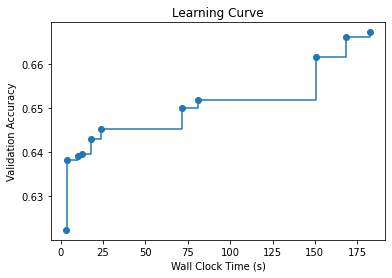

In [38]:
import matplotlib.pyplot as plt
import numpy as np

plt.title('Learning Curve')
plt.xlabel('Wall Clock Time (s)')
plt.ylabel('Validation Accuracy')
plt.scatter(time_history, 1 - np.array(valid_loss_history))
plt.step(time_history, 1 - np.array(best_valid_loss_history), where='post')
plt.show()

## 3. Comparison with alternatives


### Default LightGBM

In [39]:
from lightgbm import LGBMClassifier
lgbm = LGBMClassifier()

In [40]:
lgbm.fit(X_train, y_train)

LGBMClassifier()

In [41]:
y_pred_lgbm = lgbm.predict(X_test)

### Default XGBoost

In [42]:
from xgboost import XGBClassifier
xgb = XGBClassifier()
cat_columns = X_train.select_dtypes(include=['category']).columns
X = X_train.copy()
X[cat_columns] = X[cat_columns].apply(lambda x: x.cat.codes)


In [43]:
xgb.fit(X, y_train)

XGBClassifier()

In [44]:
X = X_test.copy()
X[cat_columns] = X[cat_columns].apply(lambda x: x.cat.codes)
y_pred_xgb = xgb.predict(X)

In [45]:
print('default xgboost accuracy', '=', 1 - sklearn_metric_loss_score('accuracy', y_pred_xgb, y_test))
print('default lgbm accuracy', '=', 1 - sklearn_metric_loss_score('accuracy', y_pred_lgbm, y_test))
print('flaml (10 min) accuracy', '=', 1 - sklearn_metric_loss_score('accuracy', y_pred, y_test))

default xgboost accuracy = 0.6492369072868309
default lgbm accuracy = 0.6602123904305652
flaml (10 min) accuracy = 0.6685849042611571


## 4. Customized Learner

Some experienced automl users may have a preferred model to tune or may already have a reasonably by-hand-tuned model before launching the automl experiment. They need to select optimal configurations for the customized model mixed with standard built-in learners. 

FLAML can easily incorporate customized/new learners (preferably with sklearn API) provided by users in a real-time manner, as demonstrated below.

### Example of Regularized Greedy Forest

[Regularized Greedy Forest](https://arxiv.org/abs/1109.0887) (RGF) is a machine learning method currently not included in FLAML. The RGF has many tuning parameters, the most critical of which are: `[max_leaf, n_iter, n_tree_search, opt_interval, min_samples_leaf]`. To run a customized/new learner, the user needs to provide the following information:
* an implementation of the customized/new learner
* a list of hyperparameter names and types
* rough ranges of hyperparameters (i.e., upper/lower bounds)
* choose initial value corresponding to low cost for cost-related hyperparameters (e.g., initial value for max_leaf and n_iter should be small)

In this example, the above information for RGF is wrapped in a python class called *MyRegularizedGreedyForest* that exposes the hyperparameters.

In [46]:
''' SKLearnEstimator is the super class for a sklearn learner '''
from flaml.model import SKLearnEstimator
from flaml import tune
from flaml.data import CLASSIFICATION


class MyRegularizedGreedyForest(SKLearnEstimator):
    def __init__(self, task='binary', **config):
        '''Constructor
        
        Args:
            task: A string of the task type, one of
                'binary', 'multiclass', 'regression'
            config: A dictionary containing the hyperparameter names
                and 'n_jobs' as keys. n_jobs is the number of parallel threads.
        '''

        super().__init__(task, **config)

        '''task=binary or multi for classification task'''
        if task in CLASSIFICATION:
            from rgf.sklearn import RGFClassifier

            self.estimator_class = RGFClassifier
        else:
            from rgf.sklearn import RGFRegressor
            
            self.estimator_class = RGFRegressor

    @classmethod
    def search_space(cls, data_size, task):
        '''[required method] search space

        Returns:
            A dictionary of the search space. 
            Each key is the name of a hyperparameter, and value is a dict with
                its domain (required) and low_cost_init_value, init_value,
                cat_hp_cost (if applicable).
                e.g.,
                {'domain': tune.randint(lower=1, upper=10), 'init_value': 1}.
        '''
        space = {        
            'max_leaf': {'domain': tune.lograndint(lower=4, upper=data_size[0]), 'init_value': 4, 'low_cost_init_value': 4},
            'n_iter': {'domain': tune.lograndint(lower=1, upper=data_size[0]), 'init_value': 1, 'low_cost_init_value': 1},
            'n_tree_search': {'domain': tune.lograndint(lower=1, upper=32768), 'init_value': 1, 'low_cost_init_value': 1},
            'opt_interval': {'domain': tune.lograndint(lower=1, upper=10000), 'init_value': 100},
            'learning_rate': {'domain': tune.loguniform(lower=0.01, upper=20.0)},
            'min_samples_leaf': {'domain': tune.lograndint(lower=1, upper=20), 'init_value': 20},
        }
        return space

    @classmethod
    def size(cls, config):
        '''[optional method] memory size of the estimator in bytes
        
        Args:
            config - the dict of the hyperparameter config

        Returns:
            A float of the memory size required by the estimator to train the
            given config
        '''
        max_leaves = int(round(config['max_leaf']))
        n_estimators = int(round(config['n_iter']))
        return (max_leaves * 3 + (max_leaves - 1) * 4 + 1.0) * n_estimators * 8

    @classmethod
    def cost_relative2lgbm(cls):
        '''[optional method] relative cost compared to lightgbm
        '''
        return 1.0


### Add Customized Learner and Run FLAML AutoML

After adding RGF into the list of learners, we run automl by tuning hyperpameters of RGF as well as the default learners. 

In [47]:
automl = AutoML()
automl.add_learner(learner_name='RGF', learner_class=MyRegularizedGreedyForest)

In [48]:
settings = {
    "time_budget": 10,  # total running time in seconds
    "metric": 'accuracy', 
    "estimator_list": ['RGF', 'lgbm', 'rf', 'xgboost'],  # list of ML learners
    "task": 'classification',  # task type    
    "log_file_name": 'airlines_experiment_custom_learner.log',  # flaml log file 
    "log_training_metric": True,  # whether to log training metric
}

automl.fit(X_train=X_train, y_train=y_train, **settings)

[flaml.automl: 08-19 14:19:25] {2447} INFO - task = classification
[flaml.automl: 08-19 14:19:25] {2449} INFO - Data split method: stratified
[flaml.automl: 08-19 14:19:25] {2452} INFO - Evaluation method: holdout
[flaml.automl: 08-19 14:19:26] {2571} INFO - Minimizing error metric: 1-accuracy
[flaml.automl: 08-19 14:19:26] {2711} INFO - List of ML learners in AutoML Run: ['RGF', 'lgbm', 'rf', 'xgboost']
[flaml.automl: 08-19 14:19:26] {3013} INFO - iteration 0, current learner RGF
[flaml.automl: 08-19 14:19:27] {3146} INFO - Estimated sufficient time budget=283078s. Estimated necessary time budget=283s.
[flaml.automl: 08-19 14:19:27] {3193} INFO -  at 1.5s,	estimator RGF's best error=0.3840,	best estimator RGF's best error=0.3840
[flaml.automl: 08-19 14:19:27] {3013} INFO - iteration 1, current learner RGF
[flaml.automl: 08-19 14:19:27] {3193} INFO -  at 2.2s,	estimator RGF's best error=0.3840,	best estimator RGF's best error=0.3840
[flaml.automl: 08-19 14:19:27] {3013} INFO - iteratio

## 5. Customized Metric

It's also easy to customize the optimization metric. As an example, we demonstrate with a custom metric function which combines training loss and validation loss as the final loss to minimize.

In [49]:
def custom_metric(X_val, y_val, estimator, labels, X_train, y_train,
                  weight_val=None, weight_train=None, config=None,
                  groups_val=None, groups_train=None):
    from sklearn.metrics import log_loss
    import time
    start = time.time()
    y_pred = estimator.predict_proba(X_val)
    pred_time = (time.time() - start) / len(X_val)
    val_loss = log_loss(y_val, y_pred, labels=labels,
                         sample_weight=weight_val)
    y_pred = estimator.predict_proba(X_train)
    train_loss = log_loss(y_train, y_pred, labels=labels,
                          sample_weight=weight_train)
    alpha = 0.5
    return val_loss * (1 + alpha) - alpha * train_loss, {
        "val_loss": val_loss, "train_loss": train_loss, "pred_time": pred_time
    }
    # two elements are returned:
    # the first element is the metric to minimize as a float number,
    # the second element is a dictionary of the metrics to log

We can then pass this custom metric function to automl's `fit` method.

In [50]:
automl = AutoML()
settings = {
    "time_budget": 10,  # total running time in seconds
    "metric": custom_metric,  # pass the custom metric funtion here
    "task": 'classification',  # task type
    "log_file_name": 'airlines_experiment_custom_metric.log',  # flaml log file
}

automl.fit(X_train=X_train, y_train=y_train, **settings)

[flaml.automl: 08-19 14:19:37] {2447} INFO - task = classification
[flaml.automl: 08-19 14:19:37] {2449} INFO - Data split method: stratified
[flaml.automl: 08-19 14:19:37] {2452} INFO - Evaluation method: holdout
[flaml.automl: 08-19 14:19:37] {2571} INFO - Minimizing error metric: customized metric
[flaml.automl: 08-19 14:19:37] {2711} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'catboost', 'xgboost', 'extra_tree', 'xgb_limitdepth', 'lrl1']
[flaml.automl: 08-19 14:19:37] {3013} INFO - iteration 0, current learner lgbm
[flaml.automl: 08-19 14:19:37] {3146} INFO - Estimated sufficient time budget=24224s. Estimated necessary time budget=595s.
[flaml.automl: 08-19 14:19:37] {3193} INFO -  at 0.8s,	estimator lgbm's best error=0.6647,	best estimator lgbm's best error=0.6647
[flaml.automl: 08-19 14:19:37] {3013} INFO - iteration 1, current learner lgbm
[flaml.automl: 08-19 14:19:37] {3193} INFO -  at 0.8s,	estimator lgbm's best error=0.6647,	best estimator lgbm's best error=0.6

## 6. Constraints

There are several types of constraints you can impose.

(1) Constraints on the AutoML process via `time_budget` and/or `max_iter`.

(2) Constraints on the constructor arguments of the estimators.
Some constraints on the estimator can be implemented via the custom learner. The following example adds a monotonicity constraint to XGBoost. This approach can be used to set any constraint that is an argument in the underlying estimator's constructor.

In [51]:
from flaml.model import XGBoostSklearnEstimator
class MonotonicXGBoostEstimator(XGBoostSklearnEstimator):
    @classmethod
    def search_space(cls, data_size, task):
        space = super().search_space(data_size)
        space.update({"monotone_constraints": {"domain": "(1, -1)"}})
        return space

automl = AutoML()
automl.add_learner(learner_name="monoton_xgb", learner_class=MonotonicXGBoostEstimator)
settings = {
    "time_budget": 10,  # total running time in seconds
    "task": 'classification',  # task type
    "estimator_list": ['monoton_xgb']
}
automl.fit(X_train, y_train, **settings)

[flaml.automl: 08-19 14:19:48] {2447} INFO - task = classification
[flaml.automl: 08-19 14:19:48] {2449} INFO - Data split method: stratified
[flaml.automl: 08-19 14:19:48] {2452} INFO - Evaluation method: holdout
[flaml.automl: 08-19 14:19:48] {2571} INFO - Minimizing error metric: 1-roc_auc
[flaml.automl: 08-19 14:19:48] {2711} INFO - List of ML learners in AutoML Run: ['monoton_xgb']
[flaml.automl: 08-19 14:19:48] {3013} INFO - iteration 0, current learner monoton_xgb
[flaml.automl: 08-19 14:19:48] {3146} INFO - Estimated sufficient time budget=27941s. Estimated necessary time budget=28s.
[flaml.automl: 08-19 14:19:48] {3193} INFO -  at 0.7s,	estimator monoton_xgb's best error=0.3586,	best estimator monoton_xgb's best error=0.3586
[flaml.automl: 08-19 14:19:48] {3013} INFO - iteration 1, current learner monoton_xgb
[flaml.automl: 08-19 14:19:48] {3193} INFO -  at 0.8s,	estimator monoton_xgb's best error=0.3521,	best estimator monoton_xgb's best error=0.3521
[flaml.automl: 08-19 14:1

(3) Constraints on the models tried in AutoML.
Users can set constraints such as the maximal number of models to try, limit on training time and prediction time per model.
* `train_time_limit`: training time in seconds.
* `pred_time_limit`: prediction time per instance in seconds.

(4) Constraints on the metrics of the ML model tried in AutoML.

In [52]:
automl = AutoML()
metric_constraints = [("train_loss", "<=", 0.1), ("val_loss", "<=", 0.1)]
settings = {
    "time_budget": 10,  # total running time in seconds
    "metric": custom_metric,  # pass the custom metric funtion here
    "task": 'classification',  # task type
    "train_time_limit": 1,
    "pred_time_limit": 0.1,
    "metric_constraints": metric_constraints,
}
automl.fit(X_train, y_train, **settings)

[flaml.automl: 08-19 14:20:01] {2447} INFO - task = classification
[flaml.automl: 08-19 14:20:01] {2449} INFO - Data split method: stratified
[flaml.automl: 08-19 14:20:01] {2452} INFO - Evaluation method: holdout
[flaml.automl: 08-19 14:20:01] {2571} INFO - Minimizing error metric: customized metric
[flaml.automl: 08-19 14:20:01] {2711} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'catboost', 'xgboost', 'extra_tree', 'xgb_limitdepth', 'lrl1']
[flaml.automl: 08-19 14:20:01] {3013} INFO - iteration 0, current learner lgbm
[flaml.automl: 08-19 14:20:01] {3146} INFO - Estimated sufficient time budget=23750s. Estimated necessary time budget=583s.
[flaml.automl: 08-19 14:20:01] {3193} INFO -  at 0.7s,	estimator lgbm's best error=0.6647,	best estimator lgbm's best error=0.6647
[flaml.automl: 08-19 14:20:01] {3013} INFO - iteration 1, current learner lgbm
[flaml.automl: 08-19 14:20:01] {3193} INFO -  at 0.8s,	estimator lgbm's best error=0.6647,	best estimator lgbm's best error=0.6

## 7. Warmstart
We can warm start the AutoML by providing starting points of hyperparameter configurstions for each estimator. For example, if you have run AutoML for one hour, after checking the results, you would like to run it for another two hours, then you can use the best configurations found for each estimator as the starting points for the new run.

In [53]:
from flaml import AutoML
automl1 = AutoML()
automl1.fit(X_train, y_train, time_budget=30)
automl2 = AutoML()
automl2.fit(X_train, y_train, time_budget=60, starting_points=automl1.best_config_per_estimator)

[flaml.automl: 08-19 14:20:12] {2447} INFO - task = classification
[flaml.automl: 08-19 14:20:12] {2449} INFO - Data split method: stratified
[flaml.automl: 08-19 14:20:12] {2452} INFO - Evaluation method: holdout
[flaml.automl: 08-19 14:20:12] {2571} INFO - Minimizing error metric: 1-roc_auc
[flaml.automl: 08-19 14:20:12] {2711} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'catboost', 'xgboost', 'extra_tree', 'xgb_limitdepth', 'lrl1']
[flaml.automl: 08-19 14:20:12] {3013} INFO - iteration 0, current learner lgbm
[flaml.automl: 08-19 14:20:12] {3146} INFO - Estimated sufficient time budget=20617s. Estimated necessary time budget=506s.
[flaml.automl: 08-19 14:20:12] {3193} INFO -  at 0.8s,	estimator lgbm's best error=0.3580,	best estimator lgbm's best error=0.3580
[flaml.automl: 08-19 14:20:12] {3013} INFO - iteration 1, current learner lgbm
[flaml.automl: 08-19 14:20:12] {3193} INFO -  at 0.8s,	estimator lgbm's best error=0.3580,	best estimator lgbm's best error=0.3580
[fla

## 8. Parallel tuning
When you have parallel resources, you can either spend them in training and keep the model search sequential, or perform parallel search.

To do parallel tuning, install the `ray` and `blendsearch` options:

In [54]:
%pip install flaml[ray,blendsearch]

Note: you may need to restart the kernel to use updated packages.


In [56]:
import ray
ray.shutdown()
ray.init(num_cpus=4)
automl = AutoML()
automl.fit(X_train, y_train, time_budget=30, n_jobs=2, n_concurrent_trials=2)

2022-08-19 14:25:07,072	INFO tune.py:747 -- Total run time: 35.26 seconds (34.16 seconds for the tuning loop).
[flaml.automl: 08-19 14:25:07] {3314} INFO - selected model: None
[flaml.automl: 08-19 14:25:13] {3457} INFO - retrain xgb_limitdepth for 6.2s
[flaml.automl: 08-19 14:25:13] {3464} INFO - retrained model: XGBClassifier(colsample_bylevel=1.0, colsample_bytree=1.0,
              learning_rate=0.29999999999999993, max_depth=6,
              min_child_weight=0.9999999999999993, n_estimators=10, n_jobs=2,
              reg_alpha=0.0009765625, reg_lambda=1.0, subsample=1.0,
              use_label_encoder=False, verbosity=0)
[flaml.automl: 08-19 14:25:13] {2742} INFO - fit succeeded
[flaml.automl: 08-19 14:25:13] {2743} INFO - Time taken to find the best model: 29.89594602584839
[flaml.automl: 08-19 14:25:13] {2754} WARNING - Time taken to find the best model is 100% of the provided time budget and not all estimators' hyperparameter search converged. Consider increasing the time bud